In [2]:
using Plots; pyplot();
using DelimitedFiles, Distributions;
using AugmentedGaussianProcesses;

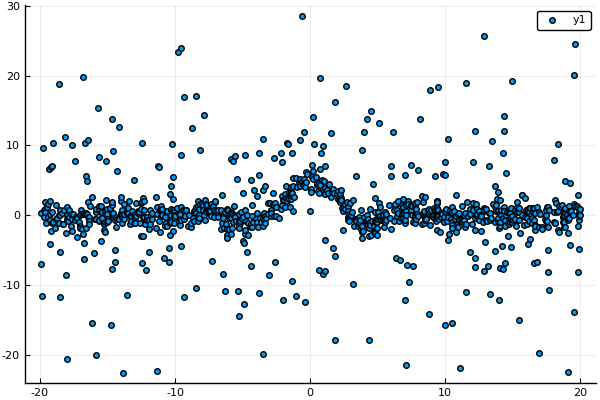

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [12]:
N = 1000
X = reshape((sort(rand(N)).-0.5).*40.0,N,1)
function latent(x)
    5.0.*sin.(x)./x
end
outliers = rand(N).>0.7
Y = (latent(X)+(1.0.-outliers).*rand(Normal(0,1),N)+outliers.*rand(Normal(0,10),N))[:];
scatter(X,Y)

In [4]:
# Run sparse classification with increasing number of inducing points
models = []
Ms = [4, 8, 16, 32, 64]
kernel = RBFKernel(1.0)
ν=10.0
for (index, num_inducing) in enumerate(Ms)
    m = SparseStudentT(X, Y, kernel=kernel,
        OptimizeIndPoints=true,Stochastic=false,Autotuning=true,m=num_inducing,ν=ν)
    println("Training with $(num_inducing) points")
    @time m.train(iterations=100)
    push!(models,m);
end

Training with 4 points
  5.946752 seconds (10.46 M allocations: 535.597 MiB, 5.34% gc time)
Training with 8 points
  0.045815 seconds (10.89 k allocations: 39.821 MiB, 24.97% gc time)
Training with 16 points
  0.077281 seconds (10.91 k allocations: 72.239 MiB, 14.54% gc time)
Training with 32 points
  0.172217 seconds (10.94 k allocations: 139.741 MiB, 13.56% gc time)
Training with 64 points
  0.367646 seconds (11.91 k allocations: 285.241 MiB, 11.49% gc time)


In [5]:
mfull = BatchStudentT(X, Y, kernel=kernel,Autotuning=true,ν=ν)
println("Training with full model")
@time mfull.train(iterations=5);
push!(models,mfull);

Training with full model
  4.689740 seconds (4.74 M allocations: 795.970 MiB, 13.50% gc time)


In [6]:
function compute_Grid(model,nGrid=50)
    mins = -20
    maxs = 20
    Xplot = collect(range(mins[1],stop=maxs[1],length=nGrid))
#     Xplot = hcat([j for i in xlin, j in ylin][:],[i for i in xlin, j in ylin][:])
    y = model.predictproba(Xplot)
    return (y,Xplot)
    end;

In [7]:
function plotdata(X,Y)
    plot(X,Y,t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
end;

In [8]:
function plotcontour(model,X,Y)
    nGrid = 100
    (predic,x) = compute_Grid(model,nGrid);
    plotdata(X,Y)
    if in(:m,fieldnames(typeof(model)))
        plot!(model.inducingPoints[:,1],zero(model.inducingPoints[:,1]),msize=2.0,color="black",t=:scatter,lab="")
    end
    return plot!(x,predic,title=(in(:m,fieldnames(typeof(model))) ? "M = $(model.m)" : "full"),color="red",lab="",linewidth=3.0)
end;

In [9]:
plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\ASUS\.julia\packages\PyCall\0jMpb\src\pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError("'c' argument has 2 elements, which is not acceptable for use with 'x' with size 4, 'y' with size 4.",)
  File "C:\Users\ASUS\.julia\conda\3\lib\site-packages\matplotlib\__init__.py", line 1805, in inner
    return func(ax, *args, **kwargs)
  File "C:\Users\ASUS\.julia\conda\3\lib\site-packages\matplotlib\axes\_axes.py", line 4234, in scatter
    .format(nc=n_elem, xs=x.size, ys=y.size)
